# Tercer parcial

Sofia Macarena Castillo Badilla

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\marub\AppData\Local\Programs\Python\Python314\python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
ensayo3_excel = r"C:\Users\marub\OneDrive\Escritorio\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx"
ensayo4_excel = r"C:\Users\marub\OneDrive\Escritorio\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx"
coordenadas_csv = r"C:\Users\marub\OneDrive\Escritorio\Neurociencias-2026-1\S03_datasets\MI_coordinates.csv"

ensayo3_dict = pd.read_excel(ensayo3_excel, sheet_name=None, index_col = 0)
ensayo4_dict = pd.read_excel(ensayo4_excel, sheet_name=None, index_col = 0)

In [3]:
# como se las llaves 
ensayo3_dict.keys()


ensayos_dfs = []
for sujeto in ensayo3_dict.keys():
    ensayos_dfs.append(ensayo3_dict[sujeto])

## filtrado de matrices

- para juntar las matrices (todos los sujetos) en 1
- porque un promedio sería muy restringido

In [4]:
# filtrado de matrices
threshold = 0.5
porcentaje = 0.6

# conjuntamos las matrices
stack = np.stack([df.values for df in ensayos_dfs])

# aplicamos el filtro a cada matriz
above = stack > threshold

N = len(ensayos_dfs)
count_above = above.sum(axis = 0)  # contar cuántos valores superan el umbral en celda

min_requerido = int(np.ceil(porcentaje*N)) # np.ceil redondea para arriba
# con esto bastará con quedarnos con las celdas de "above" que cumplan con min_requerido, para así tener el número de sujetos que superan el umbral

# Vamos a obtener a la matriz binarizada de todos
result_bool = count_above >= min_requerido

result_df = pd.DataFrame(result_bool, index=ensayos_dfs[0].index, columns=ensayos_dfs[0].columns)

<Axes: >

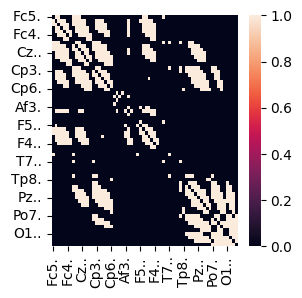

In [5]:
# Matriz binarizada --> data frame comprimido, con la info. de los 109 sujetos
plt.figure(figsize=(3,3))
sns.heatmap(result_df)

## Generar estadísticos para decidir los umbrales

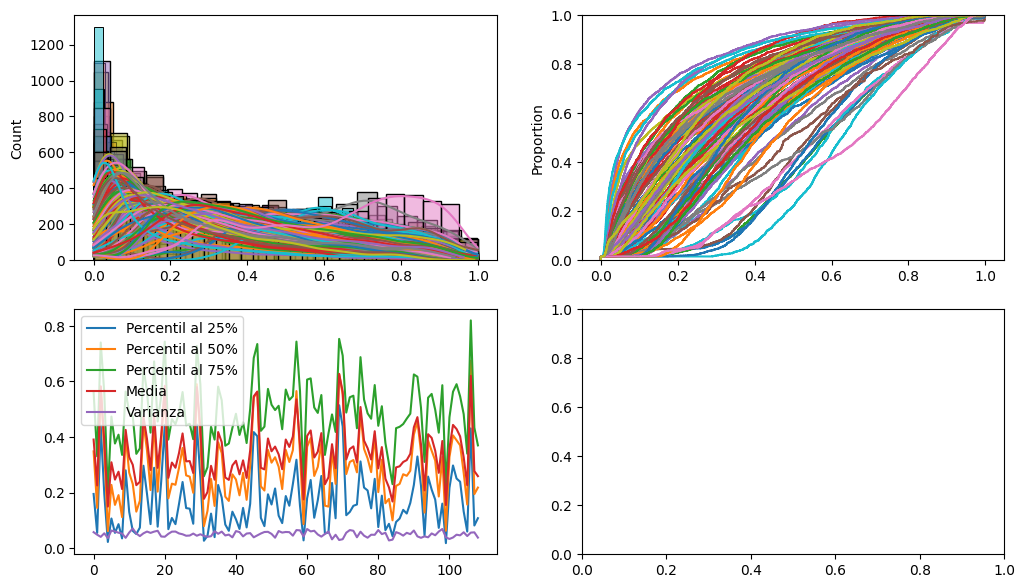

In [12]:
ensayos_dfs

th25, th50, th75, promedio, varianza = [], [], [], [], []
mu_sigma = []

fig, axes = plt.subplots(2,2, figsize=(12,7))


for sujeto in ensayos_dfs:
    # cálculo estadísticos
    data = sujeto.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))

    # plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True)  # kde=True --> para mostrar la distribución suavizada
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1])
axes[1][0].plot(th25, label="Percentil al 25%")
axes[1][0].plot(th50, label="Percentil al 50%")
axes[1][0].plot(th75, label="Percentil al 75%")
axes[1][0].plot(promedio, label="Media")
axes[1][0].plot(varianza, label="Varianza")
axes[1][0].legend()


In [9]:
from scipy import stats
stats.median_abs_deviation(th25)

np.float64(0.06955915283857339)

In [13]:
estadisticos_df = pd.DataFrame(columns=['th25', 'th50', 'th75', 'promedio', 'mu_sigma'], 
                               index=['min', 'max', 'mediana', 'cosa_rara'])

columnas = [th25, th50, th75, promedio, mu_sigma]

min_, max_, mediana_, cosa_ = [], [], [], []
for columna in columnas:
    d1, d2, d3, d4 = np.min(columna), np.max(columna), np.median(columna), stats.median_abs_deviation(columna)
    min_.append(d1)
    max_.append(d2)
    mediana_.append(d3)
    cosa_.append(d4)
estadisticos_df.loc['min'] = min_
estadisticos_df.loc['max'] = max_
estadisticos_df.loc['mediana'] = mediana_
estadisticos_df.loc['cosa_rara'] = cosa_


In [14]:
estadisticos_df = pd.DataFrame(columns=['th25', 'th50', 'th75', 'promedio', 'mu_sigma'], 
                               index=['min', 'max', 'mediana', 'cosa_rara'])

columnas = [th25, th50, th75, promedio, mu_sigma]

min_, max_, mediana_, cosa_ = [], [], [], []
for idx, columna in enumerate(estadisticos_df.columns):
    d1, d2, d3, d4 = np.min(columnas[idx]), np.max(columnas[idx]), np.median(columnas[idx]), stats.median_abs_deviation(columnas[idx])
    estadisticos_df[columna] = [d1, d2, d3, d4]

In [15]:
estadisticos_df

,th25,th50,th75,promedio,mu_sigma
min,0.018413,0.061750,0.196867,0.149821,0.186222
max,0.514472,0.674805,0.819681,0.626848,0.676548
mediana,0.144574,0.273808,0.484181,0.327700,0.389466
cosa_rara,0.069559,0.080172,0.074567,0.063494,0.060276


In [ ]:
test_df = pd.DataFrame(columns=['th25', 'th50', 'th75', 'promedio', 'mu_sigma'], 
                               index=['min', 'max', 'mediana', 'cosa_rara'])

estadísticos = [th25, th50, th75, promedio, mu_sigma]


## Crear función con toda la información anterior --> Encapsulación

In [23]:
# qué variables vamos a ir cambiando? --> threshold, porcentaje, ensayo

def capsula(lista_dfs, th, porcentaje_):
    # conjuntamos las matrices
    stack = np.stack([df.values for df in lista_dfs])

    # aplicamos el filtro a cada matriz
    above = stack > th

    N = len(lista_dfs)
    count_above = above.sum(axis = 0)  # contar cuántos valores superan el umbral en celda

    min_requerido = int(np.ceil(porcentaje_*N)) # np.ceil redondea para arriba
    # con esto bastará con quedarnos con las celdas de "above" que cumplan con min_requerido, para así tener el número de sujetos que superan el umbral
    
    # Vamos a obtener a la matriz binarizada de todos
    result_bool = count_above >= min_requerido

    result_df = pd.DataFrame(result_bool, index=lista_dfs[0].index, columns=lista_dfs[0].columns)

    return result_df

In [24]:
resultado_df = capsula(ensayos_dfs, 0.5, 0.6)

<Axes: >

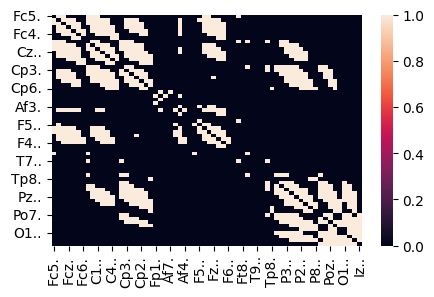

In [25]:
plt.figure(figsize = (5, 3))

sns.heatmap(resultado_df)  # --> mismo resultado que nuestro heatmap de antes, con menos líneas de código.

Text(0.5, 1.0, 'umbral = 0.2, población>60%')

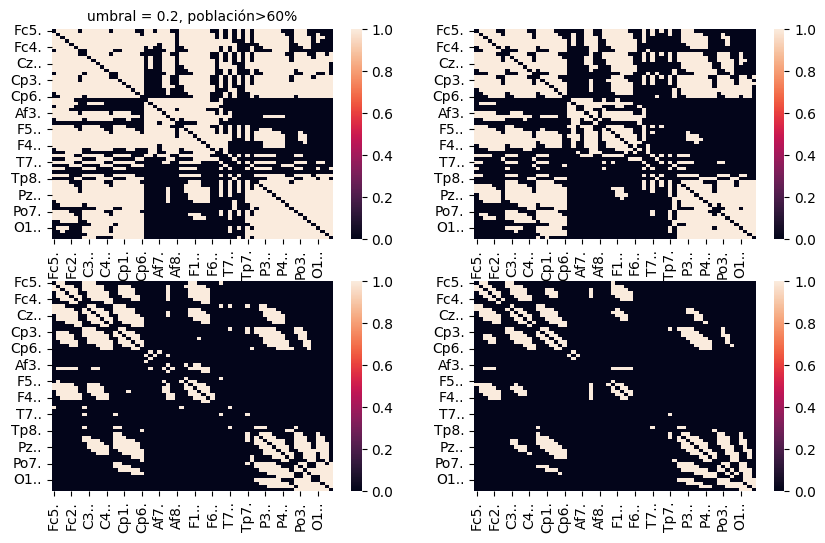

In [43]:
# comparativas entre valores de threshold, con subplots --> evaluar cuál es el mejor umbral

resultado_df1 = capsula(ensayos_dfs, 0.2, 0.6)
resultado_df2 = capsula(ensayos_dfs, 0.3, 0.6)
resultado_df3 = capsula(ensayos_dfs, 0.5, 0.6)
resultado_df4 = capsula(ensayos_dfs, 0.6, 0.6)


fig, axes = plt.subplots(2,2, figsize = (10, 6))

sns.heatmap(resultado_df1, ax=axes[0, 0])
sns.heatmap(resultado_df2, ax=axes[0, 1])
sns.heatmap(resultado_df3, ax=axes[1, 0])
sns.heatmap(resultado_df4, ax=axes[1, 1])
axes[0,0].set_title("umbral = 0.2, población>60%", fontsize = 10)

Text(0.5, 1.0, 'umbral = 0.3, población>50%')

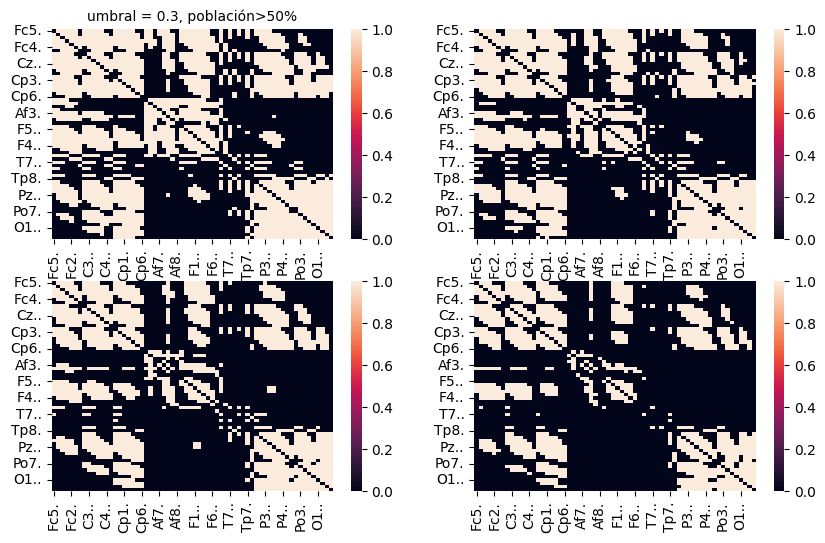

In [45]:
# ahora cambiamos los valores del porcentaje de la población

resultado_df1 = capsula(ensayos_dfs, 0.3, 0.5)
resultado_df2 = capsula(ensayos_dfs, 0.3, 0.6)
resultado_df3 = capsula(ensayos_dfs, 0.3, 0.7)
resultado_df4 = capsula(ensayos_dfs, 0.3, 0.8)


fig, axes = plt.subplots(2,2, figsize = (10, 6))

sns.heatmap(resultado_df1, ax=axes[0, 0])
sns.heatmap(resultado_df2, ax=axes[0, 1])
sns.heatmap(resultado_df3, ax=axes[1, 0])
sns.heatmap(resultado_df4, ax=axes[1, 1])
axes[0,0].set_title("umbral = 0.3, población>50%", fontsize = 10)

## Generación de resultados
- Después del análisis realizado, utilizando los mapas de calor para elegir un threshold adecuado y un porcentaje de la población que cumpla dicho umbral; se procederá a generar los resultados

Resultados a generar:
- Grafo 2d
- grafo 3d
- métricas de grafo
- gráfico de comunidades con hub

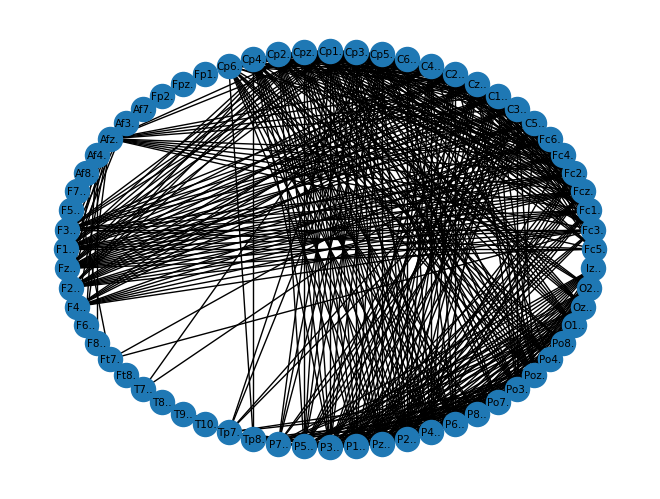

In [46]:
# umbral= 0.3, porcentaje= 0.8

# GRAFO 2D
ensayo_grafo = nx.from_pandas_adjacency(resultado_df4)
nx.draw_circular(ensayo_grafo, with_labels = True, font_size = 7.5)

In [81]:
def metricas_grafo(G):
    # Métricas
    # clústering promedio
    clust_coeff = nx.average_clustering(G)

    # longitud de camino promedio (camino más corto)
    try:                                                  # se activa cuando se genera un error
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan # red no conecta
    
    # coeficiente de mundo pequeño
    # grafo aleatorio para comparar
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)

    # modularidad
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)

    # hubs
    degree_dict = dict(G.degree())
    betwenness = nx.betweenness_centrality(G)
    betwenness = sorted(betwenness.items(), key=lambda x: x[1], reverse = True)

    # eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return  (clust_coeff, path_length, small_world_sigma, communities, modularity, betwenness, global_eff, local_eff, degree_dict)

In [82]:
# agregamos _ a las variables para que las variables globales y locales tengan nombres diferentes

(clust_coeff_, path_length_, small_world_sigma_, communities_, 
 modularity_, betwenness_, global_eff_, local_eff_, degree_dict_) = metricas_grafo(ensayo_grafo)

In [67]:
# PLOT 3D

# construir dataframe de coordenadas
eeg_coords = pd.read_csv(coordenadas_csv)
eeg_coords.set_index("canal", drop = True, inplace = True)

In [69]:
eeg_coords.loc["Fc5.", "y"]    

np.float64(0.2666)

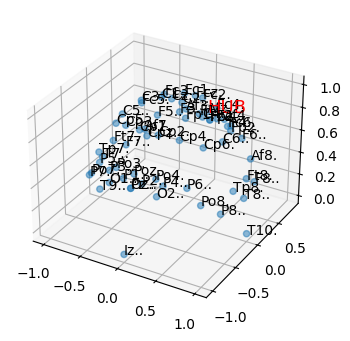

In [88]:
x, y, z = eeg_coords["x"].values, eeg_coords["y"].values, eeg_coords["z"].values
hub = betwenness_[0]

fig = plt.figure(figsize=(4,4))
axes = [fig.add_subplot(1, 1, 1, projection = "3d")]

nodes_size = [30 if idx != hub[0] else 200 for idx in eeg_coords.index] # cambiar el tamaño del nodo si es el hub
axes[0].scatter(x, y, z, alpha = 0.5)
 
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    axes[0].text(x_, y_, z_, eeg_coords.index[idx], fontsize = 10)
    if eeg_coords.index[idx] == hub[0]:
        axes[0].text(x_, y_, z_, "HUB", color = "red", fontsize = 13) # cambiar el color del texto del nodo si es el hub

- podemos generar un grafo de comunidades, lo podemos encapsular en una línea y aplicarlo a más ensayos.
- Poder hacer comparaciones entre ensayos
- generar el for sobre las comunidades en vez de los nodos para hacer las comparaciones entre comunidades